In [206]:
%load_ext autoreload
%autoreload 2
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas

##### For viewing the videos in Jupyter Notebook
import io
import base64
from IPython.display import HTML

import car_plotting as cplot

%matplotlib inline

# Vehicle Dynamics $\frac{d}{dt} \vec{x} = f(\vec{x}, \vec{u})$

In [189]:
X = cas.MX.sym('X')
Y = cas.MX.sym('Y')
Phi = cas.MX.sym('Phi')
Delta = cas.MX.sym('Delta')
V = cas.MX.sym('V')
s = cas.MX.sym('s')

delta_u = cas.MX.sym('delta_u')
v_u = cas.MX.sym('v_u')
x = cas.vertcat(X, Y, Phi, Delta, V, s)
u = cas.vertcat(delta_u, v_u)

L = 1.0
ode = cas.vertcat(V * cas.cos(Phi),
                V * cas.sin(Phi),
                V * cas.tan(Delta) / L,
                delta_u,
                v_u,
                V)

f = cas.Function('f',[x,u],[ode],['x','u'],['ode'])

In [190]:
def gen_x_next(x_k, u_k, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k+dt/2*k1, u_k)
    k3 = f(x_k+dt/2*k2, u_k)
    k4 = f(x_k+dt*k3,   u_k)
    x_next = x_k + dt/6*(k1+2*k2+2*k3+k4) 
    return x_next
# F = cas.Function('F',[x,u,t],[ode],)

#  States

$\vec{x}$ = $[x, y, \phi, \delta, V, s]^T$

$\vec{u}$ = $[\delta^u, v^u]^T$

# Discrete (integrated) dynamics $\vec{x}_{t+1} = F(\vec{x}_{t}, \vec{u}_{t})$

In [194]:
T = 3 #numbr of time horizons
dt = 0.05
N = int(T/dt) #Number of control intervals
intg_options = {}
intg_options['tf'] = dt # from dt
intg_options['simplify'] = True
intg_options['number_of_finite_elements'] = 6  #from 4

dae = {}  #What's a DAE?
dae['x'] = x
dae['p'] = u
dae['ode'] = f(x,u)
intg = cas.integrator('intg','rk', dae, intg_options)
res = intg(x0=x,p=u)
x_next = res['xf']
F = cas.Function('F',[x,u],[x_next],['x','u'],['x_next'])

# Parameterization of Desired Trajectory ($\vec{x}_d = f_d(s)$)

In [195]:
xd = s
yd = 0
phid = 0
des_traj = cas.vertcat(xd, yd, phid)

fd = cas.Function('fd',[s],[des_traj],['s'],['des_traj'])

### Solve it centrally just to warm start the solution

In [196]:
#Globally true information

min_dist = 2 * (2 * .5**2)**.5

initial_speed = 6.7 
# Initial Conditions
x0 = np.array([2*min_dist, .6*min_dist, 0, 0, initial_speed, 0]).T
x0_2 = np.array([2*min_dist,-.6*min_dist, .0, 0, initial_speed, 0]).T
x0_amb = np.array([0, 0.0, 0, 0, 1.25 * initial_speed,0]).T

n_cars = 3

In [204]:
# Generating Cost Matrices
q_lon, q_lat, q_phi, q_v, = 1., 5.0, 5.0, -.1,  #State costs
r_delta, r_vdot = 10.0, 10.0  #Control input costs

opti = cas.Opti()
n_ctrl = 2
n_state = 6

t_amb_goal = opti.variable()
# dt = T/N

#Variables
x_opt = opti.variable(n_state, N+1) # initialize X for each car that we will optimize
x2_opt = opti.variable(n_state, N+1)
xamb_opt = opti.variable(n_state, N+1)

u_opt = opti.variable(n_ctrl, N)
u2_opt = opti.variable(n_ctrl, N)
uamb_opt = opti.variable(n_ctrl, N)

p = opti.parameter(n_state, 1) #this will be the initial state
p2 = opti.parameter(n_state, 1)
pamb = opti.parameter(n_state, 1)


x_desired = opti.variable(3, N+1)
x2_desired = opti.variable(3, N+1)
xamb_desired = opti.variable(3, N+1)

#### Costs

car1_u_delta_cost = 10 * cas.sumsqr(u_opt[0,:])
car1_u_v_cost = 1 * cas.sumsqr(u_opt[1,:])

car1_lat_cost = np.sum([(-cas.sin(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
            cas.cos(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
           for k in range(N+1)])
car1_lon_cost = np.sum([(cas.cos(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
            cas.sin(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
           for k in range(N+1)]) 
car1_phi_cost = cas.sumsqr(x_desired[2,:]-x_opt[2,:]) 
car1_s_cost = cas.sumsqr(x_opt[5,N])   
phid_1 = x_opt[4,:] * cas.tan(x_opt[3,:]) / L
phid1_cost = cas.sumsqr(phid_1)

k_lat1 = 10
k_lon1 = .1
k_phi1 = 10.0
k_phid1 = 1.0

car1_costs = (car1_u_delta_cost + car1_u_v_cost + 
    k_lat1*car1_lat_cost + k_lon1*car1_lon_cost + k_phi1 * car1_phi_cost + 
              k_phid1 * phid1_cost +
             q_v*car1_s_cost)


car2_u_delta_cost = 10 * cas.sumsqr(u2_opt[0,:])
car2_u_v_cost = 1 * cas.sumsqr(u2_opt[1,:])

car2_lat_cost = np.sum([(-cas.sin(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
            cas.cos(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
           for k in range(N+1)])
car2_lon_cost = np.sum([(cas.cos(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
            cas.sin(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
           for k in range(N+1)]) 
car2_phi_cost = cas.sumsqr(x2_desired[2,:]-x2_opt[2,:]) 
car2_s_cost = cas.sumsqr(x2_opt[5,N])   
phid_2 = x2_opt[4,:] * cas.tan(x2_opt[3,:]) / L
phid2_cost =cas.sumsqr(phid_2)    


k_lat2 = 10
k_lon2 = .10    
k_phi2 = 10.0
k_phid2 = 1.0

car2_costs = (car2_u_delta_cost + car2_u_v_cost + 
    k_lat2*car2_lat_cost + k_lon2*car2_lon_cost + k_phi2*car2_phi_cost + 
              k_phid2*phid2_cost + q_v*car2_s_cost)    

#     amb_u_v_cost = np.sum([cas.transpose(uamb_opt[:,k]) @ R_k @ uamb_opt[:,k] for k in range(N)])

amb_u_delta_cost = 10 * cas.sumsqr(uamb_opt[0,:])
amb_u_v_cost = 0.1 * cas.sumsqr(uamb_opt[1,:])

amb_u_change_cost = cas.sumsqr(uamb_opt[:,1:N-1] - uamb_opt[:,0:N-2])

amb_lat_cost = np.sum([(-cas.sin(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
            cas.cos(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
           for k in range(N+1)])


amb_lon_cost = np.sum([(cas.cos(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
            cas.sin(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
           for k in range(N+1)]) 

amb_phi_cost = cas.sumsqr(xamb_desired[2,:]-xamb_opt[2,:]) 
amb_s_cost = cas.sumsqr(xamb_opt[4,:])  

phid_amb= xamb_opt[4,:] * cas.tan(xamb_opt[3,:]) / L
phidamb_cost =cas.sumsqr(phid_amb)   

k_latamb = 10
k_lonamb = .10     # Require that the ambulance get's to its goal.  T captures the amount of time to that location.
# xamb_goal =  15.0
# opti.subject_to(xamb_opt[0, N] >= xamb_goal) #Last point must be greater than 5 m/s i.e. goal
# opti.subject_to( opti.bounded(T_min, T, T_max))   
k_phiamb = 10.0
k_phidamb = 1.0
q_T = 100
amb_costs = (amb_u_delta_cost + amb_u_v_cost + 
             k_latamb*amb_lat_cost + k_lonamb*amb_lon_cost + k_phiamb*amb_phi_cost + 
             k_phidamb * phidamb_cost + q_v*amb_s_cost + amb_u_change_cost
            )


theta_1 = np.pi/4
theta_2 = np.pi/4
theta_amb = 0
######## optimization  ##################################
opti.minimize(np.cos(theta_amb)*amb_costs + np.sin(theta_amb)*(car1_costs + car2_costs) + 
              (np.cos(theta_1)*car1_costs + np.sin(theta_1)*amb_costs) + 
              (np.cos(theta_2)*car2_costs + np.sin(theta_2)*amb_costs)
             )    
##########################################################
#constraints

for k in range(N):
    opti.subject_to( x_opt[:, k+1] == gen_x_next(x_opt[:, k], u_opt[:, k], dt))

for k in range(N+1):
    opti.subject_to( x_desired[:, k] == fd(x_opt[-1, k]) ) #This should be the trajectory dynamic constraint        


opti.subject_to(opti.bounded(-np.pi/6, u_opt[0,:], np.pi/6))
opti.subject_to(opti.bounded(-4, u_opt[1,:], 4)) # 0-60 around 4 m/s^2
v_max = 10
opti.subject_to(opti.bounded(0, x_opt[4,:],v_max))    
opti.subject_to(x_opt[:,0] == p)


#Just repeat constraints for x2
for k in range(N):
    opti.subject_to( x2_opt[:, k+1] == gen_x_next(x2_opt[:, k], u2_opt[:, k], dt))
for k in range(N+1):
    opti.subject_to( x2_desired[:, k] == fd(x2_opt[-1, k]) ) #This should be the trajectory dynamic constraint             


opti.subject_to(opti.bounded(-np.pi/6, u2_opt[0,:], np.pi/6))
opti.subject_to(opti.bounded(-4, u2_opt[1,:], 4))
v_max = 10
opti.subject_to(opti.bounded(0, x2_opt[4,:],v_max))    
opti.subject_to(x2_opt[:,0] == p2)

#ambulance
for k in range(N):
    opti.subject_to( xamb_opt[:, k+1] == gen_x_next(xamb_opt[:, k], uamb_opt[:, k], dt))
for k in range(N+1):
    opti.subject_to( xamb_desired[:, k] == fd(xamb_opt[-1, k]) ) #This should be the trajectory dynamic constraint             


opti.subject_to(opti.bounded(-np.pi/6, uamb_opt[0,:], np.pi/6))
opti.subject_to(opti.bounded(-4, uamb_opt[1,:], 4))
v_max = 20
opti.subject_to(opti.bounded(0, xamb_opt[4,:],v_max))    
opti.subject_to(xamb_opt[:,0] == pamb)    


#     min_dist = 0.6
for k in range(N+1):
    opti.subject_to( cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]) > min_dist**2 )
    opti.subject_to( cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 )
    opti.subject_to( cas.sumsqr(x2_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 )

# constraining x,y to help out
opti.subject_to( opti.bounded(-1, x_opt[0,:], v_max * T) )
opti.subject_to( opti.bounded(-1, x2_opt[0,:], v_max * T) )
opti.subject_to( opti.bounded(-1, xamb_opt[0,:], v_max * T) )
opti.subject_to( opti.bounded(-10, x_opt[1,:], 10) )
opti.subject_to( opti.bounded(-10, x2_opt[1,:], 10) )
opti.subject_to( opti.bounded(-10, xamb_opt[1,:], 10) )

# constrain crazy turns
opti.subject_to( opti.bounded(-np.pi/2, x_opt[2,:], np.pi/2) )
opti.subject_to( opti.bounded(-np.pi/2, x2_opt[2,:], np.pi/2) )
opti.subject_to( opti.bounded(-np.pi/2, xamb_opt[2,:], np.pi/2) )    

# constrain the lane deviations to prevent wacky solutions
#     opti.subject_to( opti.bounded(-5, x_opt[0,:] - x_desired[0,:], 5))
#     opti.subject_to( opti.bounded(-5, x2_opt[0,:] - x2_desired[0,:], 5))
opti.subject_to( opti.bounded(-5, xamb_opt[0,:] - xamb_desired[0,:], 5))
opti.subject_to( opti.bounded(-10, x_opt[1,:] - x_desired[1,:], 10))
opti.subject_to( opti.bounded(-10, x2_opt[1,:] - x2_desired[1,:], 10))
opti.subject_to( opti.bounded(-10, xamb_opt[1,:] - xamb_desired[1,:], 10))


opti.solver('ipopt',{'warn_initial_bounds':True},{'print_level':5})

opti.set_value(p,x0)
opti.set_value(p2,x0_2)
opti.set_value(pamb,x0_amb) 

In [205]:
opti

Opti(Opti {
  instance #18
  #variables: 9 (nx = 2007)
  #parameters: 3 (np = 18)
  #constraints: 571 (ng = 3166)
  CasADi solver needs updating.
})

In [198]:
# opti.set_initial(T, 9.0)
sol = opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     6150
Number of nonzeros in inequality constraint Jacobian.:     2312
Number of nonzeros in Lagrangian Hessian.............:     6124

Total number of variables............................:     2007
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1647
Total number of inequality constraints...............:     1519
        inequality constraints with only lower bounds:      183
   inequality constraints with lower and upper bounds:     1336
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  87 -8.9121216e+02 5.35e-05 1.89e+01  -2.5 2.13e+00  -0.5 5.22e-02 1.03e-01f  1
  88 -8.9839874e+02 5.06e-05 1.46e+01  -2.5 7.45e-01  -0.1 9.94e-02 2.51e-01f  1
  89 -9.0141245e+02 4.98e-05 1.49e+01  -2.5 1.96e+00  -0.5 6.75e-02 4.52e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -9.0439015e+02 4.96e-05 1.51e+01  -2.5 4.77e+01    -  3.22e-03 3.67e-03f  1
  91 -9.0588734e+02 4.76e-05 1.32e+01  -2.5 7.69e-01  -0.1 2.60e-02 5.21e-02f  1
  92 -9.0838200e+02 4.90e-05 1.91e+01  -2.5 5.59e+01    -  2.48e-05 3.58e-03f  1
  93 -9.0852737e+02 4.90e-05 2.09e+01  -2.5 4.03e+00  -0.6 1.42e-02 1.92e-03f  1
  94 -9.1357046e+02 4.81e-05 1.99e+01  -2.5 1.26e+01    -  1.71e-04 2.06e-02f  1
  95 -9.1566756e+02 4.52e-05 1.70e+01  -2.5 7.14e-01  -0.2 1.52e-02 7.94e-02f  1
  96 -9.1836290e+02 4.46e-05 2.11e+01  -2.5 5.80e+00    -  3.78e-04 1.96e-02f  1
  97 -9.1861987e+02 4.46e-05 2.55e+01  -2.5 4.62e+00  -0.6 2.69e-02 4.18e-03f  1
  98 -9.2209841e+02 4.81e-05

 274 -1.4675489e+03 6.43e-04 5.22e+01  -2.5 1.19e+01  -0.9 6.67e-02 1.45e-02f  1
 275 -1.4687339e+03 6.41e-04 5.21e+01  -2.5 4.57e+01  -1.3 6.20e-03 2.18e-03f  1
 276 -1.4746890e+03 6.14e-04 4.99e+01  -2.5 1.11e+01  -0.9 6.85e-02 4.19e-02f  1
 277 -1.4749668e+03 6.13e-04 4.98e+01  -2.5 1.44e+01    -  7.43e-03 2.11e-03f  1
 278 -1.4833515e+03 6.04e-04 4.84e+01  -2.5 3.33e+01    -  2.73e-03 2.86e-02f  1
 279 -1.4863209e+03 5.98e-04 4.78e+01  -2.5 2.81e+01    -  2.96e-02 1.19e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 -1.4942243e+03 5.87e-04 4.61e+01  -2.5 2.63e+01    -  1.65e-02 3.52e-02f  1
 281 -1.4999003e+03 5.78e-04 4.51e+01  -2.5 2.75e+01    -  1.91e-03 2.31e-02f  1
 282 -1.5037226e+03 5.71e-04 4.42e+01  -2.5 2.42e+01    -  4.81e-02 1.78e-02f  1
 283 -1.5072004e+03 5.67e-04 4.38e+01  -2.5 3.81e+01    -  1.15e-04 9.96e-03f  1
 284 -1.5080674e+03 5.66e-04 4.36e+01  -2.5 1.89e+02  -1.4 5.48e-03 4.08e-04f  1
 285 -1.5153867e+03 5.41e-04

 368 -1.8926344e+03 3.96e-04 1.14e+02  -2.5 1.38e+02    -  2.21e-05 1.18e-02f  1
 369 -1.8927471e+03 3.96e-04 1.14e+02  -2.5 5.51e+02    -  2.08e-03 3.08e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370 -1.8961902e+03 3.97e-04 1.14e+02  -2.5 1.31e+04    -  1.65e-06 3.94e-05f  1
 371 -1.8963582e+03 3.96e-04 1.14e+02  -2.5 2.88e+01    -  1.78e-02 8.34e-04f  1
 372 -1.9043914e+03 3.84e-04 1.10e+02  -2.5 3.18e+01    -  2.89e-03 3.69e-02f  1
 373 -1.9103014e+03 3.76e-04 1.07e+02  -2.5 3.61e+01    -  1.73e-02 2.47e-02f  1
 374 -1.9114561e+03 3.75e-04 1.07e+02  -2.5 2.90e+02  -2.5 2.05e-04 6.27e-04f  1
 375 -1.9181040e+03 3.71e-04 1.06e+02  -2.5 8.56e+01  -2.1 3.00e-02 1.21e-02f  1
 376 -1.9182402e+03 3.71e-04 1.06e+02  -2.5 1.21e+02    -  8.25e-03 1.75e-04f  1
 377 -1.9255209e+03 3.71e-04 1.05e+02  -2.5 2.59e+02    -  2.82e-05 4.47e-03f  1
 378 -1.9301916e+03 3.72e-04 1.05e+02  -2.5 3.90e+02    -  4.23e-03 1.88e-03f  1
 379 -1.9428563e+03 3.81e-04

 465 -2.3166880e+03 3.11e-04 6.39e+01  -2.5 3.24e+02    -  5.31e-03 6.96e-04f  1
 466 -2.3207093e+03 3.14e-04 6.38e+01  -2.5 2.69e+02    -  8.91e-03 4.29e-03f  1
 467 -2.3208684e+03 3.14e-04 6.34e+01  -2.5 3.93e+01    -  6.30e-04 1.27e-03f  1
 468 -2.3282224e+03 2.96e-04 4.60e+01  -2.5 4.15e+01    -  3.71e-02 5.90e-02f  1
 469 -2.3339245e+03 2.83e-04 7.12e+01  -2.5 4.27e+01    -  3.84e-03 4.66e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470 -2.3343874e+03 2.83e-04 7.11e+01  -2.5 6.40e+02    -  2.89e-04 2.39e-04f  1
 471 -2.3362408e+03 2.81e-04 6.98e+01  -2.5 8.50e+01    -  4.26e-02 7.64e-03f  1
 472 -2.3393279e+03 2.79e-04 6.89e+01  -2.5 7.97e+01    -  1.30e-02 1.38e-02f  1
 473 -2.3464599e+03 2.76e-04 6.65e+01  -2.5 7.63e+01    -  2.75e-02 3.45e-02f  1
 474 -2.3467514e+03 2.75e-04 7.25e+01  -2.5 3.44e+01    -  1.73e-02 3.26e-03f  1
 475 -2.3496761e+03 2.74e-04 6.63e+01  -2.5 9.85e+01    -  1.46e-04 1.04e-02f  1
 476 -2.3504249e+03 2.74e-04

In [199]:
optional_suffix = "_initialspeed"
subdir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + optional_suffix
folder = "results/" + subdir_name + "/"
os.makedirs(folder)
os.makedirs(folder+"imgs/")
print(folder)

results/20200213-121825_initialspeed/


## Warm Start

In [ ]:
speeding_amb_u = np.zeros((2,N))
speeding_amb_u[1,:10] = np.ones((1,10)) * 3.999

x = np.zeros((6,N+1))
x1 = np.zeros((6,N+1))
xamb = np.zeros((6,N+1))
u0 = np.zeros((2,N))
u0[0,:10] = np.ones((1,10)) * np.pi/5
u0[1,:10] = np.ones((1,10)) * 3.999

u1 = np.zeros((2,N))
u1[0,:10] = np.ones((1,10)) * -np.pi/5
u1[1,:10] = np.ones((1,10)) * 3.999

x[:,0] = x0
x1[:,0] = x0_2
xamb[:,0] = x0_amb
for t in range(N):
    x[:,t+1:t+2] = F(x[:,t],u0[:,t])
    x1[:,t+1:t+2] = F(x1[:,t],u1[:,t])
    xamb[:,t+1:t+2] = F(xamb[:,t],speeding_amb_u[:,t])

    

opti.set_initial(uamb_opt, speeding_amb_u)
opti.set_initial(u_opt, u0)
opti.set_initial(u2_opt, u0)
opti.set_initial(xamb_opt, xamb)
opti.set_initial(x2_opt, x1)
opti.set_initial(x_opt, x)



In [185]:
opti.solve()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     5130
Number of nonzeros in inequality constraint Jacobian.:     1932
Number of nonzeros in Lagrangian Hessian.............:     5114

Total number of variables............................:     1677
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1377
Total number of inequality constraints...............:     1269
        inequality constraints with only lower bounds:      153
   inequality constraints with lower and upper bounds:     1116
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  83  4.4489632e+02 5.77e-05 1.43e+01  -2.5 1.82e+00  -0.2 2.68e-01 1.40e-01f  1
  84  4.1940860e+02 1.38e-04 1.42e+01  -2.5 8.79e+00  -0.6 9.09e-02 7.33e-02f  1
  85  4.0556290e+02 1.63e-04 1.07e+01  -2.5 1.79e+02  -1.1 4.99e-03 2.23e-03f  1
  86  3.4996521e+02 4.46e-04 1.32e+01  -2.5 6.58e+00  -0.7 1.28e-01 2.06e-01f  1
  87  3.2209312e+02 4.94e-04 1.39e+01  -2.5 1.42e+01  -1.2 3.76e-02 4.70e-02f  1
  88  3.1222823e+02 4.59e-04 1.39e+01  -2.5 5.66e+02    -  2.19e-04 1.09e-03f  1
  89  3.1046960e+02 4.59e-04 1.55e+01  -2.5 2.41e+01  -1.6 5.84e-03 1.77e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.8102647e+02 5.31e-04 1.72e+01  -2.5 2.62e+01  -2.1 1.27e-02 2.39e-02f  1
  91  2.0315813e+02 7.84e-03 2.49e+01  -2.5 2.95e+02  -2.6 6.95e-04 1.36e-02f  1
  92  1.8680968e+02 7.65e-03 2.59e+01  -2.5 2.42e+01  -1.3 4.34e-02 2.45e-02f  1
  93  1.8249473e+02 7.62e-03 2.86e+01  -2.5 4.56e+01  -1.7 1.69e-02 3.42e-03f  1
  94  1.2515868e+02 7.59e-03

 182 -1.3086031e+03 1.07e-03 9.21e+00  -2.5 3.75e+00  -0.5 1.42e-01 2.72e-02f  1
 183 -1.3131663e+03 6.55e-04 5.16e+00  -2.5 1.14e+00  -0.1 1.00e+00 4.35e-01f  1
 184 -1.3181867e+03 1.27e-04 1.01e+00  -2.5 4.27e-01   0.4 1.00e+00 1.00e+00f  1
 185 -1.3211377e+03 1.09e-04 1.09e+00  -2.5 1.92e+00  -0.1 2.80e-01 1.66e-01f  1
 186 -1.3270838e+03 3.32e-05 1.18e+00  -2.5 5.61e-01   0.3 1.00e+00 1.00e+00f  1
 187 -1.3301151e+03 3.06e-05 1.25e+00  -2.5 2.81e+00  -0.2 3.87e-01 9.70e-02f  1
 188 -1.3303208e+03 3.05e-05 1.72e+01  -2.5 5.31e+00  -0.6 3.10e-01 3.33e-03f  1
 189 -1.3379150e+03 3.36e-04 2.48e+01  -2.5 4.80e+01    -  1.57e-01 4.09e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 -1.3488716e+03 1.12e-03 1.94e+01  -2.5 5.06e+01    -  3.97e-04 5.48e-02f  1
 191 -1.3521345e+03 1.13e-03 1.96e+01  -2.5 1.02e+02  -1.1 1.10e-02 5.13e-03f  1
 192 -1.3561176e+03 1.10e-03 1.75e+01  -2.5 4.36e+00  -0.7 1.33e-01 1.11e-01f  1
 193 -1.3640519e+03 2.35e-03

 282 -1.7986268e+03 1.19e-03 9.48e+00  -2.5 3.33e+01    -  5.35e-02 1.01e-01f  1
 283 -1.7993792e+03 1.18e-03 9.36e+00  -2.5 1.96e+01    -  5.45e-02 1.31e-02f  1
 284 -1.8028991e+03 1.09e-03 8.20e+00  -2.5 8.42e+00    -  1.40e-01 1.24e-01f  1
 285 -1.8044405e+03 1.03e-03 7.68e+00  -2.5 8.36e+00    -  5.43e-02 6.46e-02f  1
 286 -1.8073642e+03 1.02e-03 7.61e+00  -2.5 1.55e+02    -  6.72e-05 6.72e-03f  1
 287 -1.8097620e+03 9.93e-04 7.41e+00  -2.5 2.75e+01  -1.8 3.75e-02 2.75e-02f  1
 288 -1.8139381e+03 9.77e-04 1.04e+01  -2.5 8.51e+01  -2.3 4.63e-03 1.61e-02f  1
 289 -1.8149688e+03 9.68e-04 7.65e+00  -2.5 3.47e+01  -1.9 6.25e-02 9.18e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 -1.8152563e+03 9.68e-04 1.72e+01  -2.5 5.70e+02    -  5.27e-03 1.61e-04f  1
 291 -1.8192524e+03 9.64e-04 1.56e+01  -2.5 3.39e+02    -  2.27e-03 4.02e-03f  1
 292 -1.8273185e+03 8.47e-04 1.26e+01  -2.5 2.37e+01  -1.5 6.30e-04 1.24e-01f  1
 293 -1.8388581e+03 4.28e-04

 380 -2.2542928e+03 1.59e-03 1.09e+01  -2.5 1.70e+01    -  6.37e-02 1.34e-01f  1
 381 -2.2638164e+03 1.59e-03 1.44e+01  -2.5 6.78e+02    -  3.55e-05 8.19e-03f  1
 382 -2.2795084e+03 1.58e-03 1.65e+01  -2.5 1.15e+02  -2.4 5.51e-02 6.82e-02f  1
 383 -2.2808749e+03 1.55e-03 1.05e+01  -2.5 2.68e+01  -2.0 1.20e-01 1.77e-02f  1
 384 -2.2810397e+03 1.55e-03 2.18e+01  -2.5 4.85e+01    -  1.02e-01 1.64e-03f  1
 385 -2.2953765e+03 1.72e-03 8.57e+00  -2.5 4.68e+01    -  7.12e-02 1.74e-01f  1
 386 -2.3051845e+03 1.93e-03 1.62e+01  -2.5 5.40e+01    -  6.16e-04 1.07e-01f  1
 387 -2.3052337e+03 1.93e-03 1.11e+01  -2.5 2.51e+01    -  8.72e-02 1.07e-03h  1
 388 -2.3073525e+03 1.83e-03 1.13e+01  -2.5 1.90e+01    -  8.95e-02 6.37e-02f  1
 389 -2.3129512e+03 1.76e-03 1.01e+01  -2.5 7.76e+01    -  1.90e-04 4.41e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390 -2.3270411e+03 1.63e-03 9.72e+00  -2.5 9.58e+01  -2.5 4.66e-02 7.92e-02f  1
 391 -2.3337376e+03 1.49e-03

 477 -2.8362714e+03 8.58e-04 3.51e+01  -2.5 9.08e+02  -3.6 1.69e-03 6.72e-03f  1
 478 -2.8375302e+03 8.60e-04 3.53e+01  -2.5 4.86e+02    -  3.53e-03 1.89e-03f  1
 479 -2.8435247e+03 8.86e-04 3.48e+01  -2.5 2.92e+02    -  1.52e-02 1.50e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 -2.8481104e+03 7.37e-04 2.23e+01  -2.5 1.77e+01  -2.3 9.46e-03 1.69e-01f  1
 481 -2.8503009e+03 7.25e-04 2.41e+01  -2.5 8.97e+01  -2.8 2.41e-02 1.77e-02f  1
 482 -2.8504371e+03 7.25e-04 2.72e+01  -2.5 1.52e+03  -3.2 8.72e-04 6.50e-05f  1
 483 -2.8518556e+03 7.27e-04 2.63e+01  -2.5 3.19e+03    -  2.10e-05 3.35e-04f  1
 484 -2.8580519e+03 7.85e-04 2.43e+01  -2.5 5.32e+02  -3.7 4.90e-03 9.17e-03f  1
 485 -2.8616281e+03 7.02e-04 1.75e+01  -2.5 1.99e+01  -2.4 9.65e-01 1.06e-01f  1
 486 -2.8628820e+03 6.95e-04 1.64e+01  -2.5 6.62e+01  -2.9 8.18e-02 1.38e-02f  1
 487 -2.8693510e+03 8.26e-04 1.72e+01  -2.5 4.01e+02  -3.3 4.30e-03 1.37e-02f  1
 488 -2.8699611e+03 8.21e-04

 574 -3.2829696e+03 9.69e-04 1.52e+01  -2.5 2.48e+02  -3.6 3.37e-02 4.13e-03f  1
 575 -3.2855254e+03 9.73e-04 1.71e+01  -2.5 1.35e+03    -  6.31e-03 1.96e-03f  1
 576 -3.2876925e+03 9.61e-04 1.69e+01  -2.5 1.75e+02    -  2.59e-03 1.20e-02f  1
 577 -3.2925978e+03 9.35e-04 1.64e+01  -2.5 1.71e+02    -  4.09e-02 2.85e-02f  1
 578 -3.2962321e+03 9.11e-04 1.60e+01  -2.5 1.40e+02    -  3.02e-02 2.68e-02f  1
 579 -3.3043151e+03 9.09e-04 1.57e+01  -2.5 1.32e+03    -  3.45e-05 8.85e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580 -3.3050607e+03 8.99e-04 1.88e+01  -2.5 7.62e+01  -3.2 3.24e-01 1.17e-02f  1
 581 -3.3096851e+03 8.78e-04 1.67e+01  -2.5 2.35e+02  -3.7 9.95e-03 2.63e-02f  1
 582 -3.3099790e+03 8.77e-04 1.81e+01  -2.5 4.70e+02    -  6.25e-03 7.79e-04f  1
 583 -3.3200668e+03 9.07e-04 1.67e+01  -2.5 1.56e+03  -4.1 2.37e-05 9.37e-03f  1
 584 -3.3228051e+03 9.04e-04 1.65e+01  -2.5 2.91e+02  -3.7 1.21e-02 1.21e-02f  1
 585 -3.3271081e+03 8.88e-04

OptiSol(Opti {
  instance #16
  #variables: 9 (nx = 1677)
  #parameters: 3 (np = 18)
  #constraints: 481 (ng = 2646)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

In [200]:
x_warm = sol.value(x_opt)
u_warm = sol.value(u_opt)
x2_warm = sol.value(x2_opt)
u2_warm = sol.value(u2_opt)
xamb_warm = sol.value(xamb_opt)
uamb_warm = sol.value(uamb_opt)

x_des = sol.value(x_desired)
x2_des = sol.value(x2_desired)
xamb_des = sol.value(xamb_desired)

In [201]:
cplot.plot_cars(x_warm, x2_warm, xamb_warm, folder)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [202]:
if CIRCLES:
    vid_fname = folder + subdir_name + 'circle.mp4'
else:
    vid_fname = folder + subdir_name + 'car.mp4'    
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

Saving video to: results/20200213-121825_initialspeed/20200213-121825_initialspeedcar.mp4


In [203]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


In [120]:
car1_v_cost = car1_s_cost
car2_v_cost = car2_s_cost
amb_v_cost = amb_s_cost

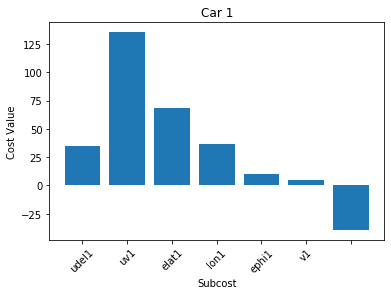

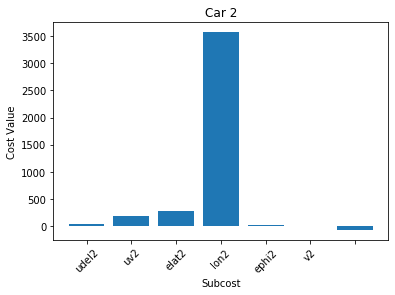

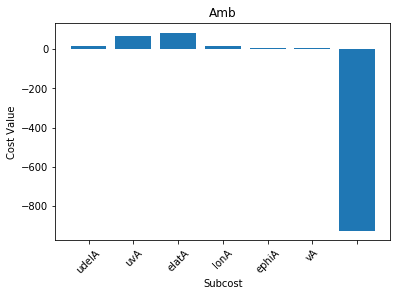

Text(0, 0.5, 'Cost Value')

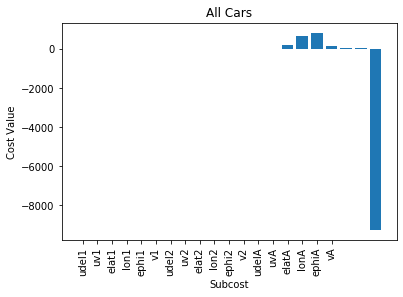

In [121]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, k_lat1*car1_lat_cost, k_lon1*car1_lon_cost, k_phi1*car1_phi_cost, k_phid1*phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, k_phi2*car2_phi_cost, k_phid2*phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost,k_phiamb*amb_phi_cost, k_phidamb*phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

## Optimization

In [ ]:
## Best response for vehicle 1
opti = cas.Opti()
n_ctrl = 2
n_state = 6

#Variables
x_opt = opti.variable(n_state, N+1) # initialize X for each car that we will optimize
u_opt = opti.variable(n_ctrl, N)



# These are now parameters!!
x2_opt = opti.parameter(n_state, N+1)
xamb_opt = opti.parameter(n_state, N+1)
u2_opt = opti.parameter(n_ctrl, N)
uamb_opt = opti.parameter(n_ctrl, N)

p = opti.parameter(n_state, 1) #this will be the initial state
p2 = opti.parameter(n_state, 1)
pamb = opti.parameter(n_state, 1)


x_desired = opti.variable(3, N+1)
x2_desired = opti.variable(3, N+1)
xamb_desired = opti.variable(3, N+1)

#### Costs

car1_u_delta_cost = 10 * cas.sumsqr(u_opt[0,:])
car1_u_v_cost = 1 * cas.sumsqr(u_opt[1,:])

car1_lat_cost = np.sum([(-cas.sin(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
            cas.cos(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
           for k in range(N+1)])
car1_lon_cost = np.sum([(cas.cos(x_desired[2,k]) * (x_opt[0,k]-x_desired[0,k]) + 
            cas.sin(x_desired[2,k]) * (x_opt[1,k]-x_desired[1,k]))**2
           for k in range(N+1)]) 
car1_phi_cost = cas.sumsqr(x_desired[2,:]-x_opt[2,:]) 
car1_v_cost = cas.sumsqr(x_opt[4,:])   
phid_1 = x_opt[4,:] * cas.tan(x_opt[3,:]) / L
phid1_cost = cas.sumsqr(phid_1)

k_lat1 = 10
k_lon1 = 10
k_phid1 = 1.0

car1_costs = (car1_u_delta_cost + car1_u_v_cost + 
    k_lat1*car1_lat_cost + k_lon1*car1_lon_cost + car1_phi_cost + 
              k_phid1 * phid1_cost +
             q_v*car1_v_cost)


car2_u_delta_cost = 10 * cas.sumsqr(u2_opt[0,:])
car2_u_v_cost = 1 * cas.sumsqr(u2_opt[1,:])

car2_lat_cost = np.sum([(-cas.sin(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
            cas.cos(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
           for k in range(N+1)])
car2_lon_cost = np.sum([(cas.cos(x2_desired[2,k]) * (x2_opt[0,k]-x2_desired[0,k]) + 
            cas.sin(x2_desired[2,k]) * (x2_opt[1,k]-x2_desired[1,k]))**2
           for k in range(N+1)]) 
car2_phi_cost = cas.sumsqr(x2_desired[2,:]-x2_opt[2,:]) 
car2_v_cost = cas.sumsqr(x2_opt[4,:])   
phid_2 = x2_opt[4,:] * cas.tan(x2_opt[3,:]) / L
phid2_cost =cas.sumsqr(phid_2)    


k_lat2 = 10
k_lon2 = 10    
k_phid2 = 1.0

car2_costs = (car2_u_delta_cost + car2_u_v_cost + 
    k_lat2*car2_lat_cost + k_lon2*car2_lon_cost + car2_phi_cost + 
              k_phid2*phid2_cost + q_v*car2_v_cost)    

R_k = 1*R_k

#     amb_u_v_cost = np.sum([cas.transpose(uamb_opt[:,k]) @ R_k @ uamb_opt[:,k] for k in range(N)])

amb_u_delta_cost = 10 * cas.sumsqr(uamb_opt[0,:])
amb_u_v_cost = 0.1 * cas.sumsqr(uamb_opt[1,:])

amb_lat_cost = np.sum([(-cas.sin(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
            cas.cos(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
           for k in range(N+1)])


amb_lon_cost = np.sum([(cas.cos(xamb_desired[2,k]) * (xamb_opt[0,k]-xamb_desired[0,k]) + 
            cas.sin(xamb_desired[2,k]) * (xamb_opt[1,k]-xamb_desired[1,k]))**2
           for k in range(N+1)]) 

amb_phi_cost = cas.sumsqr(xamb_desired[2,:]-xamb_opt[2,:]) 
amb_v_cost = cas.sumsqr(xamb_opt[4,:])  

phid_amb= xamb_opt[4,:] * cas.tan(xamb_opt[3,:]) / L
phidamb_cost =cas.sumsqr(phid_amb)   

k_latamb = 20
k_lonamb = 10        
k_phidamb = 1.0
amb_costs = (amb_u_delta_cost + amb_u_v_cost + 
             k_latamb*amb_lat_cost + k_lonamb*amb_lon_cost + amb_phi_cost + 
             k_phidamb * phidamb_cost + q_v*amb_v_cost
            )


theta_1 = np.pi/4
theta_2 = np.pi/4
theta_amb = 0
######## optimization  ##################################
opti.minimize(np.cos(theta_1)*car1_costs + np.sin(theta_1)*amb_costs)    
##########################################################



#constraints

for k in range(N):
    opti.subject_to( x_opt[:, k+1] == F(x_opt[:, k], u_opt[:, k]))

for k in range(N+1):
    opti.subject_to( x_desired[:, k] == fd(x_opt[-1, k]) ) #This should be the trajectory dynamic constraint        


opti.subject_to(opti.bounded(-np.pi/6, u_opt[0,:], np.pi/6))
opti.subject_to(opti.bounded(-4, u_opt[1,:], 4)) # 0-60 around 4 m/s^2
v_max = 10
opti.subject_to(opti.bounded(0, x_opt[4,:],v_max))    
opti.subject_to(x_opt[:,0] == p)

#     min_dist = 0.6
for k in range(N+1):
    opti.subject_to( cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]) > min_dist**2 )
    opti.subject_to( cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]) > min_dist**2 )

# constraints to help out
opti.subject_to( opti.bounded(-1, x_opt[0,:], 30) )
opti.subject_to( opti.bounded(-10, x_opt[1,:], 10) )
opti.subject_to( opti.bounded(-np.pi/2, x_opt[2,:], np.pi/4) )


# constrain the lane deviations to prevent wacky solutions
#     opti.subject_to( opti.bounded(-5, x_opt[0,:] - x_desired[0,:], 5))
#     opti.subject_to( opti.bounded(-5, x2_opt[0,:] - x2_desired[0,:], 5))
opti.subject_to( opti.bounded(-5, xamb_opt[0,:] - xamb_desired[0,:], 5))
opti.subject_to( opti.bounded(-10, x_opt[1,:] - x_desired[1,:], 10))

opti.solver('ipopt',{'warn_initial_bounds':True},{'print_level':0})

opti.set_value(p,x0)
opti.set_value(p2,x0_2)
opti.set_value(pamb,x0_amb)     




In [ ]:
opti2 = cas.Opti()
n_ctrl = 2
n_state = 6

#Variables
x2_opt2 = opti2.variable(n_state, N+1)
u2_opt2 = opti2.variable(n_ctrl, N)

### Agent 2 has these as parameters!!!
x_opt2 = opti2.parameter(n_state, N+1) # initialize X for each car that we will opti2mize
xamb_opt2 = opti2.parameter(n_state, N+1)
u_opt2 = opti2.parameter(n_ctrl, N)
uamb_opt2 = opti2.parameter(n_ctrl, N)

p_2 = opti2.parameter(n_state, 1) #this will be the initial state
p2_2 = opti2.parameter(n_state, 1)
pamb_2 = opti2.parameter(n_state, 1)

x_desired_2 = opti2.variable(3, N+1)
x2_desired_2 = opti2.variable(3, N+1)
xamb_desired_2 = opti2.variable(3, N+1)

#### Costs
car1_u_delta_cost_2 = 10 * cas.sumsqr(u_opt2[0,:])
car1_u_v_cost_2 = 1 * cas.sumsqr(u_opt2[1,:])
car1_lat_cost_2 = np.sum([(-cas.sin(x_desired_2[2,k]) * (x_opt2[0,k]-x_desired_2[0,k]) + 
            cas.cos(x_desired_2[2,k]) * (x_opt2[1,k]-x_desired_2[1,k]))**2
           for k in range(N+1)])
car1_lon_cost_2 = np.sum([(cas.cos(x_desired_2[2,k]) * (x_opt2[0,k]-x_desired_2[0,k]) + 
            cas.sin(x_desired_2[2,k]) * (x_opt2[1,k]-x_desired_2[1,k]))**2
           for k in range(N+1)]) 
car1_phi_cost_2 = cas.sumsqr(x_desired_2[2,:]-x_opt2[2,:]) 
car1_v_cost_2 = cas.sumsqr(x_opt2[4,:])   
phid_1_2 = x_opt2[4,:] * cas.tan(x_opt2[3,:]) / L
phid1_cost_2 = cas.sumsqr(phid_1_2)

k_lat1_2 = 10
k_lon1_2 = 10
k_phid1_2 = 1.0

car1_costs_2 = (car1_u_delta_cost_2 + car1_u_v_cost_2 + 
    k_lat1_2*car1_lat_cost_2 + k_lon1_2*car1_lon_cost_2 + car1_phi_cost_2 + 
              k_phid1_2 * phid1_cost_2 +
             q_v*car1_v_cost_2)


car2_u_delta_cost_2 = 10 * cas.sumsqr(u2_opt2[0,:])
car2_u_v_cost_2 = 1 * cas.sumsqr(u2_opt2[1,:])
car2_lat_cost_2 = np.sum([(-cas.sin(x2_desired_2[2,k]) * (x2_opt2[0,k]-x2_desired_2[0,k]) + 
            cas.cos(x2_desired_2[2,k]) * (x2_opt2[1,k]-x2_desired_2[1,k]))**2
           for k in range(N+1)])
car2_lon_cost_2 = np.sum([(cas.cos(x2_desired_2[2,k]) * (x2_opt2[0,k]-x2_desired_2[0,k]) + 
            cas.sin(x2_desired_2[2,k]) * (x2_opt2[1,k]-x2_desired_2[1,k]))**2
           for k in range(N+1)]) 
car2_phi_cost_2 = cas.sumsqr(x2_desired_2[2,:]-x2_opt2[2,:]) 
car2_v_cost_2 = cas.sumsqr(x2_opt2[4,:])   
phid_2_2 = x2_opt2[4,:] * cas.tan(x2_opt2[3,:]) / L
phid2_cost_2 =cas.sumsqr(phid_2_2)    

k_lat2_2 = 10
k_lon2_2 = 10    
k_phid2_2 = 1.0

car2_costs_2 = (car2_u_delta_cost_2 + car2_u_v_cost_2 + 
    k_lat2*car2_lat_cost_2 + k_lon2*car2_lon_cost_2 + car2_phi_cost_2 + 
              k_phid2_2*phid2_cost_2 + q_v*car2_v_cost_2)    

R_k_2 = 1*R_k

#     amb_u_v_cost = np.sum([cas.transpose(uamb_opt2[:,k]) @ R_k @ uamb_opt2[:,k] for k in range(N)])

amb_u_delta_cost_2 = 10 * cas.sumsqr(uamb_opt2[0,:])
amb_u_v_cost_2 = 0.1 * cas.sumsqr(uamb_opt2[1,:])
amb_lat_cost_2 = np.sum([(-cas.sin(xamb_desired_2[2,k]) * (xamb_opt2[0,k]-xamb_desired_2[0,k]) + 
            cas.cos(xamb_desired_2[2,k]) * (xamb_opt2[1,k]-xamb_desired_2[1,k]))**2
           for k in range(N+1)])
amb_lon_cost_2 = np.sum([(cas.cos(xamb_desired_2[2,k]) * (xamb_opt2[0,k]-xamb_desired_2[0,k]) + 
            cas.sin(xamb_desired_2[2,k]) * (xamb_opt2[1,k]-xamb_desired_2[1,k]))**2
           for k in range(N+1)]) 
amb_phi_cost_2 = cas.sumsqr(xamb_desired_2[2,:]-xamb_opt2[2,:]) 
amb_v_cost_2 = cas.sumsqr(xamb_opt2[4,:])  
phid_amb_2 = xamb_opt2[4,:] * cas.tan(xamb_opt2[3,:]) / L
phidamb_cost_2 =cas.sumsqr(phid_amb_2)   

k_latamb_2 = 20
k_lonamb_2 = 10        
k_phidamb_2 = 1.0
amb_costs_2 = (amb_u_delta_cost_2 + amb_u_v_cost_2 + 
             k_latamb_2*amb_lat_cost_2 + k_lonamb_2*amb_lon_cost_2 + amb_phi_cost_2 + 
             k_phidamb_2 * phidamb_cost_2 + q_v*amb_v_cost_2
            )

theta_2 = np.pi/4
######## opti2mization  ##################################
opti2.minimize(np.cos(theta_2)*car2_costs_2 + np.sin(theta_2)*amb_costs_2)    
########################################################
#constraints

#Just repeat constraints for x2
for k in range(N):
    opti2.subject_to( x2_opt2[:, k+1] == F(x2_opt2[:, k], u2_opt2[:, k]))
for k in range(N+1):
    opti2.subject_to( x2_desired_2[:, k] == fd(x2_opt2[-1, k]) ) #This should be the trajectory dynamic constraint             


opti2.subject_to(opti2.bounded(-np.pi/6, u2_opt2[0,:], np.pi/6))
opti2.subject_to(opti2.bounded(-4, u2_opt2[1,:], 4))
v_max = 10
opti2.subject_to(opti2.bounded(0, x2_opt2[4,:],v_max))    
opti2.subject_to(x2_opt2[:,0] == p2_2)

#     min_dist = 0.6
for k in range(N+1):
    opti2.subject_to( cas.sumsqr(x_opt2[0:2,k] - x2_opt2[0:2,k]) > min_dist**2 )
    opti2.subject_to( cas.sumsqr(x2_opt2[0:2,k] - xamb_opt2[0:2,k]) > min_dist**2 )




# constraints to help out
opti2.subject_to( opti2.bounded(-1, x2_opt2[0,:], 30) )
opti2.subject_to( opti2.bounded(-10, x2_opt2[1,:], 10) )
opti2.subject_to( opti2.bounded(-np.pi/4, x2_opt2[2,:], np.pi/4) )

# constrain the lane deviations to prevent wacky solutions
#     opti2.subject_to( opti2.bounded(-5, x_opt2[0,:] - x_desired_2[0,:], 5))
#     opti2.subject_to( opti2.bounded(-5, x2_opt2[0,:] - x2_desired_2[0,:], 5))
opti2.subject_to( opti2.bounded(-10, x2_opt2[1,:] - x2_desired_2[1,:], 10))


opti2.solver('ipopt',{'warn_initial_bounds':True},{'print_level':10})

opti2.set_value(p_2,x0)
opti2.set_value(p2_2,x0_2)
opti2.set_value(pamb_2,x0_amb)         

### Ambulance Optimization

In [ ]:
opti3 = cas.Opti()
n_ctrl = 2
n_state = 6

#Variables
xamb_opt3 = opti3.variable(n_state, N+1)
uamb_opt3 = opti3.variable(n_ctrl, N)

### Agent 2 has these as parameters!!!
x_opt3 = opti3.parameter(n_state, N+1) # initialize X for each car that we will opti3mize
x2_opt3 = opti3.parameter(n_state, N+1)
u_opt3 = opti3.parameter(n_ctrl, N)
u2_opt3 = opti3.parameter(n_ctrl, N)

p_3 = opti3.parameter(n_state, 1) #this will be the initial state
p2_3 = opti3.parameter(n_state, 1)
pamb_3 = opti3.parameter(n_state, 1)

x_desired_3 = opti3.variable(3, N+1)
x2_desired_3 = opti3.variable(3, N+1)
xamb_desired_3 = opti3.variable(3, N+1)

#### Costs
amb_u_delta_cost_3 = 10 * cas.sumsqr(uamb_opt3[0,:])
amb_u_v_cost_3 = 0.1 * cas.sumsqr(uamb_opt3[1,:])
amb_lat_cost_3 = np.sum([(-cas.sin(xamb_desired_3[2,k]) * (xamb_opt3[0,k]-xamb_desired_3[0,k]) + 
            cas.cos(xamb_desired_3[2,k]) * (xamb_opt3[1,k]-xamb_desired_3[1,k]))**2
           for k in range(N+1)])
amb_lon_cost_3 = np.sum([(cas.cos(xamb_desired_3[2,k]) * (xamb_opt3[0,k]-xamb_desired_3[0,k]) + 
            cas.sin(xamb_desired_3[2,k]) * (xamb_opt3[1,k]-xamb_desired_3[1,k]))**2
           for k in range(N+1)]) 
amb_phi_cost_3 = cas.sumsqr(xamb_desired_3[2,:]-xamb_opt3[2,:]) 
amb_v_cost_3 = cas.sumsqr(xamb_opt3[4,:])  
phid_amb_3 = xamb_opt3[4,:] * cas.tan(xamb_opt3[3,:]) / L
phidamb_cost_3 =cas.sumsqr(phid_amb_3)   

k_latamb_3 = 20
k_lonamb_3 = 10        
k_phidamb_3 = 1.0
amb_costs_3 = (amb_u_delta_cost_3 + amb_u_v_cost_3 + 
             k_latamb_3*amb_lat_cost_3 + k_lonamb_3*amb_lon_cost_3 + amb_phi_cost_3 + 
             k_phidamb_3 * phidamb_cost_3 + q_v*amb_v_cost_3
            )

theta_3 = np.pi/4
######## opti3mization  ##################################
opti3.minimize(amb_costs_3)    
########################################################
#constraints

#Just repeat constraints for x2
for k in range(N):
    opti3.subject_to( xamb_opt3[:, k+1] == F(xamb_opt3[:, k], u2_opt3[:, k]))
for k in range(N+1):
    opti3.subject_to( xamb_desired_3[:, k] == fd(xamb_opt3[-1, k]) ) #This should be the trajectory dynamic constraint             


opti3.subject_to(opti3.bounded(-np.pi/6, uamb_opt3[0,:], np.pi/6))
opti3.subject_to(opti3.bounded(-4, uamb_opt3[1,:], 4))
v_max = 10
opti3.subject_to(opti3.bounded(0, xamb_opt3[4,:],v_max))    
opti3.subject_to(xamb_opt3[:,0] == pamb_3)

#     min_dist = 0.6
for k in range(N+1):
    opti3.subject_to( cas.sumsqr(xamb_opt3[0:2,k] - x2_opt3[0:2,k]) > min_dist**2 )
    opti3.subject_to( cas.sumsqr(x_opt3[0:2,k] - xamb_opt3[0:2,k]) > min_dist**2 )




# constraints to help out
opti3.subject_to( opti3.bounded(-1, xamb_opt3[0,:], 30) )
opti3.subject_to( opti3.bounded(-10, xamb_opt3[1,:], 10) )
opti3.subject_to( opti3.bounded(-np.pi/4, xamb_opt3[2,:], np.pi/4) )

# constrain the lane deviations to prevent wacky solutions
opti3.subject_to( opti3.bounded(-10, xamb_opt3[1,:] - xamb_desired_3[1,:], 10))


opti3.solver('ipopt',{'warn_initial_bounds':True},{'print_level':5})

opti3.set_value(p_3,x0)
opti3.set_value(p2_3,x0_2)
opti3.set_value(pamb_3,x0_amb)         

# Best Response, V1

In [ ]:
opti.set_value(x2_opt, x2_warm)
opti.set_value(xamb_opt, xamb_warm)
opti.set_value(u2_opt, u2_warm)
opti.set_value(uamb_opt, uamb_warm)

opti.set_initial(x_opt, x_warm)
opti.set_initial(u_opt, u_warm)

In [ ]:
sol = opti.solve()

In [ ]:
x1_1 = opti.debug.value(x_opt)
x2_1 = opti.debug.value(x2_opt)
xamb_1 = opti.debug.value(xamb_opt)

x_des = opti.debug.value(x_desired)
# x2_des = opti.debug.value(x2_desired)

In [ ]:
for k in range(N+1):

    fig, ax = ego_car.get_frame(x1_1[:,k])
    fig, ax = ego_car.get_frame(x2_1[:,k], ax)
    fig, ax = ego_car.get_frame(xamb_1[:,k], ax, amb=True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
#     ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     

In [ ]:
vid_fname = folder + 'car1.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
video = io.open(vid_fname, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [ ]:
x_warm = sol.value(x_opt)
u_warm = sol.value(u_opt)
x2_warm = sol.value(x2_opt)
u2_warm = sol.value(u2_opt)
xamb_warm = sol.value(xamb_opt)
uamb_warm = sol.value(uamb_opt)

In [ ]:
x_warm = sol.value(x_opt)
u_warm = sol.value(u_opt)

BR_iteration = 0


opti2.set_value(x_opt2, x_warm)
opti2.set_value(u_opt2, u_warm)

opti2.set_value(xamb_opt2, xamb_warm)
opti2.set_value(uamb_opt2, uamb_warm)


# opti2.set_value(xamb_opt2, sol.value(xamb_opt))
# opti2.set_value(uamb_opt2, sol.value(uamb_opt))

opti2.set_initial(x2_opt2, x2_warm)
opti2.set_initial(u2_opt2, u2_warm)
sol2 = opti2.solve()
x2_warm = sol2.value(x2_opt2)
u2_warm = sol2.value(u2_opt2)

opti3.set_value(x_opt3, x_warm)
opti3.set_value(u_opt3, u_warm)

opti3.set_value(x2_opt3, x2_warm)
opti3.set_value(u2_opt3, u2_warm)

opti3.set_initial(xamb_opt3, xamb_warm)
opti3.set_initial(uamb_opt3, uamb_warm)    
sol3 = opti3.solve()
xamb_warm = sol3.value(xamb_opt3)
uamb_warm = sol3.value(uamb_opt3)


opti.set_value(x2_opt, x2_warm)
opti.set_value(xamb_opt, xamb_warm)
opti.set_value(u2_opt, u2_warm)
opti.set_value(uamb_opt, uamb_warm)

opti.set_initial(x_opt, x_warm)
opti.set_initial(u_opt, u_warm)    
sol = opti.solve()
x_warm = sol.value(x_opt)
u_warm = sol.value(u_opt)

# x2_warm = sol.value(x2_opt)
# u2_warm = sol.value(u2_opt)
# xamb_warm = sol.value(xamb_opt)
# uamb_warm = sol.value(uamb_opt)

#     x_des = sol/

for k in range(N+1):

    fig, ax = ego_car.get_frame(x_warm[:,k])
    fig, ax = ego_car.get_frame(x2_warm[:,k], ax)
    fig, ax = ego_car.get_frame(xamb_warm[:,k], ax, amb=True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)         

vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
opti3.set_value(x_opt3, x_warm)
opti3.set_value(u_opt3, u_warm)

opti3.set_value(x2_opt3, x2_warm)
opti3.set_value(u2_opt3, u2_warm)

opti3.set_initial(xamb_opt3, xamb_warm)
opti3.set_initial(uamb_opt3, uamb_warm)    
sol3 = opti3.solve()

In [ ]:
x_plot = opti3.debug.value(x_opt3)
x2_plot = opti3.debug.value(x2_opt3)
xamb_plot = opti3.debug.value(xamb_opt3)

BR_iteration = 2


for k in range(N+1):

    fig, ax = ego_car.get_frame(x_plot[:,k],None, False,min_dist,True)
    fig, ax = ego_car.get_frame(x2_plot[:,k], ax, False,min_dist,True)
    fig, ax = ego_car.get_frame(xamb_plot[:,k], ax, False,min_dist,True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)         

vid_fname = folder + 'circ'+'%02d'%BR_iteration + 'car.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))


In [ ]:
x_plot = sol2.value(x_opt2)
x2_plot = sol2.value(x2_opt2)
xamb_plot = sol2.value(xamb_opt2)

x2_plot = sol2.value(x2_opt2)
x_plot = x_warm
xamb_plot = xamb_warm





BR_iteration = 1


for k in range(N+1):

    fig, ax = ego_car.get_frame(x_plot[:,k],None, False,min_dist,True)
    fig, ax = ego_car.get_frame(x2_plot[:,k], ax, False,min_dist,True)
    fig, ax = ego_car.get_frame(xamb_plot[:,k], ax, False,min_dist,True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)         

vid_fname = folder + 'circ'+'%02d'%BR_iteration + 'car.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
for BR_iteration in range(20):
    opti2.set_value(x_opt2, sol.value(x_opt))
    opti2.set_value(u_opt2, sol.value(u_opt))

    opti2.set_value(xamb_opt2, sol.value(xamb_opt))
    opti2.set_value(uamb_opt2, sol.value(uamb_opt))

    opti2.set_initial(x2_opt2, sol.value(x2_opt))
    opti2.set_initial(u2_opt2, sol.value(u2_opt))
    sol2 = opti2.solve()

    opti3.set_value(x_opt3, sol2.value(x_opt2))
    opti3.set_value(u_opt3, sol2.value(u_opt2))

    opti3.set_value(x2_opt3, sol2.value(x2_opt2))
    opti3.set_value(u2_opt3, sol2.value(uamb_opt2))

    opti3.set_initial(xamb_opt3, sol2.value(xamb_opt2))
    opti3.set_initial(uamb_opt3, sol2.value(uamb_opt2))    
    sol3 = opti3.solve()
    
    
    opti.set_value(x2_opt, sol3.value(x2_opt3))
    opti.set_value(xamb_opt, sol3.value(xamb_opt3))
    opti.set_value(u2_opt, sol3.value(u2_opt3))
    opti.set_value(uamb_opt, sol3.value(uamb_opt3))

    opti.set_initial(x_opt, sol3.value(x_opt3))
    opti.set_initial(u_opt, sol3.value(u_opt3))    
    sol = opti.solve()
    
    x_warm = sol.value(x_opt)
    u_warm = sol.value(u_opt)
    x2_warm = sol.value(x2_opt)
    u2_warm = sol.value(u2_opt)
    xamb_warm = sol.value(xamb_opt)
    uamb_warm = sol.value(uamb_opt)

#     x_des = sol/

    for k in range(N+1):

        fig, ax = ego_car.get_frame(x_warm[:,k])
        fig, ax = ego_car.get_frame(x2_warm[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_warm[:,k], ax, amb=True)


#         ax.plot(x_des[0,:], x_des[1,:], '--')
#         ax.plot(x2_des[0,:], x2_des[1,:], '--')        

        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))

        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)         

    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    if os.path.exists(vid_fname):
        os.remove(vid_fname)
    cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
    os.system(cmd)
    print('Saving video to: {}'.format(vid_fname))

In [ ]:
for BR_iteration in range(20):        
    vid_fname = folder + '%02d'%BR_iteration + 'car.mp4'
    
    print('Saving video to: {}'.format(vid_fname))

## Best Response V2

In [ ]:
x1 = sol3.value(x_opt3)
x2 = sol3.value(x2_opt3)
xamb = sol3.value(xamb_opt3)
x_des = sol3.value(xamb_desired_3)

for k in range(N+1):

    fig, ax = ego_car.get_frame(x1[:,k])
    fig, ax = ego_car.get_frame(x2[:,k], ax)
    fig, ax = ego_car.get_frame(xamb[:,k], ax, amb=True)

    
    ax.plot(x_des[0,:], x_des[1,:], '--')
#     ax.plot(x2_des[0,:], x2_des[1,:], '--')        

    ax = plt.gca()
    window_width = 24
    window_height = window_width
    xmin, xmax = -1, -1+window_width
    ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
    ax.set_ylim((ymin, ymax))
    ax.set_xlim((xmin, xmax))

    fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
    plt.close(fig)     
    
vid_fname = folder + 'caramb.mp4'
if os.path.exists(vid_fname):
    os.remove(vid_fname)
cmd = 'ffmpeg -r 16 -f image2 -i {}imgs/%03d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p {}'.format(folder, vid_fname)
os.system(cmd)
print('Saving video to: {}'.format(vid_fname))

In [ ]:
car1_sub_costs = [car1_u_delta_cost, car1_u_v_cost, 10*car1_lat_cost, 10*car1_lon_cost, car1_phi_cost, phid1_cost, q_v*car1_v_cost] 
car1_sub_costs_labels = ['udel1', 'uv1', 'elat1', 'lon1', 'ephi1', 'v1']
plt.bar(range(len(car1_sub_costs)), [sol.value(c) for c in car1_sub_costs])
plt.xticks(range(len(car1_sub_costs)), car1_sub_costs_labels,rotation=45)
plt.title('Car 1')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

car2_sub_costs = [car2_u_delta_cost, car2_u_v_cost, 10*car2_lat_cost, 10*car2_lon_cost, car2_phi_cost, phid2_cost, q_v*car2_v_cost] 
car2_sub_costs_labels = ['udel2', 'uv2', 'elat2', 'lon2', 'ephi2', 'v2']
plt.bar(range(len(car2_sub_costs)), [sol.value(c) for c in car2_sub_costs])
plt.xticks(range(len(car2_sub_costs)), car2_sub_costs_labels,rotation=45)
plt.title('Car 2')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

amb_sub_costs = [amb_u_delta_cost, amb_u_v_cost, 10*amb_lat_cost, 10*amb_lon_cost, amb_phi_cost, phidamb_cost, q_v*amb_v_cost] 
amb_sub_costs_labels = ['udelA', 'uvA', 'elatA', 'lonA', 'ephiA', 'vA']
plt.bar(range(len(amb_sub_costs)), [sol.value(c) for c in amb_sub_costs])
plt.xticks(range(len(amb_sub_costs)), amb_sub_costs_labels,rotation=45)

plt.title('Amb')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")
plt.show()

all_costs = [0.1*c for c in car1_sub_costs] + [0.1 for c in car2_sub_costs] + [10*c for c in amb_sub_costs]
all_labels = car1_sub_costs_labels + car2_sub_costs_labels + amb_sub_costs_labels
plt.bar(range(len(all_costs)), [sol.value(c) for c in all_costs])
plt.xticks(range(len(all_labels)), all_labels,rotation=90)
plt.title('All Cars')
plt.xlabel("Subcost")
plt.ylabel("Cost Value")

In [ ]:
sol.value(x_opt)[3:5, 10:20]

In [ ]:
dt

In [ ]:
plt.plot(opti.debug.value(x_opt)[4,:],'o',c='b')
plt.plot(opti.debug.value(x2_opt)[4,:],'o',c='g')
plt.plot(opti.debug.value(xamb_opt)[4,:],'o',c='r')
plt.ylabel("Velocity")
plt.show()

In [ ]:
plt.plot(opti.debug.value(u_opt)[1,:],'o',c='b')
plt.plot(opti.debug.value(u2_opt)[1,:],'o',c='g')
plt.plot(opti.debug.value(uamb_opt)[1,:],'o',c='r')
plt.ylabel("Acceleration $\delta V_u$")
plt.show()

In [ ]:
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.hlines(min_dist,0,50)
plt.ylabel('Intervehicle Distance')
plt.ylim([-.1, 2*min_dist])

In [ ]:
plt.plot([opti.debug.value(slack1) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='b')
plt.plot([opti.debug.value(slack2) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='r')
plt.plot([opti.debug.value(slack3) for k in range(opti.debug.value(x_opt).shape[1])],'.',c='g')


# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='g')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='b')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(x_opt[0:2,k] - xamb_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'o',c='g')
# plt.plot([np.sqrt(opti.debug.value(cas.sumsqr(xamb_opt[0:2,k] - x2_opt[0:2,k]))) for k in range(opti.debug.value(x_opt).shape[1])],'x',c='r')

plt.ylabel('slack')
# plt.ylim([.7,.71])

In [ ]:
if not PLOT_LIVE:
    for k in range(N+1):
        
        fig, ax = ego_car.get_frame(x_mpc[:,k])
        fig, ax = ego_car.get_frame(x2_mpc[:,k], ax)
        fig, ax = ego_car.get_frame(xamb_mpc[:,k], ax, amb=True)
        
        ax.plot(x_des[0,:], x_des[1,:], '--')
        ax.plot(x2_des[0,:], x2_des[1,:], '--')        
        
        ax = plt.gca()
        window_width = 24
        window_height = window_width
        xmin, xmax = -1, -1+window_width
        ymin, ymax = -int(window_height/4.0), int(window_height/4.0)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
        
        fig.savefig(folder + 'imgs/' '{:03d}.png'.format(k))
        plt.close(fig)     